# Jatin Deshpande (21b080014) - True Beacon Assignment

## Pairs Trading Strategy

### Before creating our strategy let us first analyse our data and the check for the pair given for pairs trading strategy:

In [446]:
# importing required libraries 
import pandas as pd
import numpy as np
from scipy.stats import zscore
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [447]:
# Taking data relevant to indian trading time which is given.
data=pd.read_parquet("data.parquet")
data = data.between_time('09:15', '15:30').copy()
data

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28


In [448]:
# Handling the missing values 
missing_values = data.isnull().sum()
if missing_values.sum() > 0:
    data_filled = data.fillna(method='ffill')
else:
    data_filled = data

### Here we are using ffill because we don't want to miss important data_points from other row if we omit and also we dont want to exit/entry our trade due to such values, which can also happen if we bfill

## Now if we can use them for paris trading we need to perform the following test, where we will check if they are cointegrated or not.

### Here we use the "Engle Granger tests" - The idea of Engle-Granger test is simple. We perform a linear regression between the two asset prices and check if the residual is stationary using the Augmented Dick-Fuller (ADF) test. 

#### Reference for the test and related concepts: 1) https://hudsonthames.org/an-introduction-to-cointegration/    
#### 2) https://arxiv.org/pdf/2211.07080

In [449]:
_, pvalue, _ = coint(data_filled['banknifty'],data_filled['nifty'])

if pvalue <0.05:
    print("The time series are cointegrated.")
else:
    print("The time series are not cointegrated.")

The time series are cointegrated.


## Base model - A very simple z-score based model to give trading signals

In [450]:
data_filled['spread'] = data_filled['banknifty'] - data_filled['nifty']

In [451]:
data_filled['z_score'] = zscore(data_filled['spread'])

data_filled.head()

,banknifty,nifty,tte,spread,z_score
time,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,0.543747
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,0.491736
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,0.464628
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.540526
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.553505


### Some important assumptions: 1) We will make two column one for long trade i.e we are going long on the spread if the value of the spread goes below a arbiratry threshold from mean and one for short trade i.e short on spread if value of spread goes above a arbiratry threshold from mean. 2) We will not make multiple long or short trades at a time. 3) We will exit the trade if it goes beyond 5 days i.e 1875 minutes 3) We also assume that P/L for a trade will be difference between the P/L when we bought and P/L when we sold.

### At each point of trade we are assuming that we know the entire data i.e all the datapoints from where we calculate the mean, this is not at all possible in actual market, also the assumption that we are exiting after 5 days is only limited to this assignment in practice we may wish to hold trade longer even if we follow a medium frequency trading strategy.

In [452]:
data_filled.insert(loc=5,column='signal_1',value=0)
data_filled.insert(loc=6,column='signal_2',value=0)


i=0
while i<len(data_filled)-30:
    #print(i)
    count=1
    if data_filled.iloc[i,4]>=1.5:
        data_filled.iloc[i,5]=2
        while ((i+count)<(len(data_filled)-1) and data_filled.iloc[i+count,4]>=0.5 and count<=1875):
            #print(count)
            data_filled.iloc[i+count,5]=1
            count=count+1
        data_filled.iloc[(i+count),5]=3
    if count>1875:
        i = i+count+1
    else:
        i=i+count

i=0
while i<len(data_filled)-30:
    #print(i)
    count=1
    if data_filled.iloc[i,4]<=-1.5:
        data_filled.iloc[i,6]=2
        while ((i+count)<(len(data_filled)-1) and data_filled.iloc[i+count,4]<=-0.5 and count<=1875):
            #print(count)
            data_filled.iloc[i+count,6]=1
            count=count+1
        data_filled.iloc[(i+count),6]=3
        
    if count>1875:
        i = i+count+1
    else:
        i=i+count


data_filled

,banknifty,nifty,tte,spread,z_score,signal_1,signal_2
time,,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,0.543747,0,0
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,0.491736,0,0
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,0.464628,0,0
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.540526,0,0
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.553505,0,0
...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,-1.731344,0,1
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,-1.792623,0,1
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,-1.754778,0,1


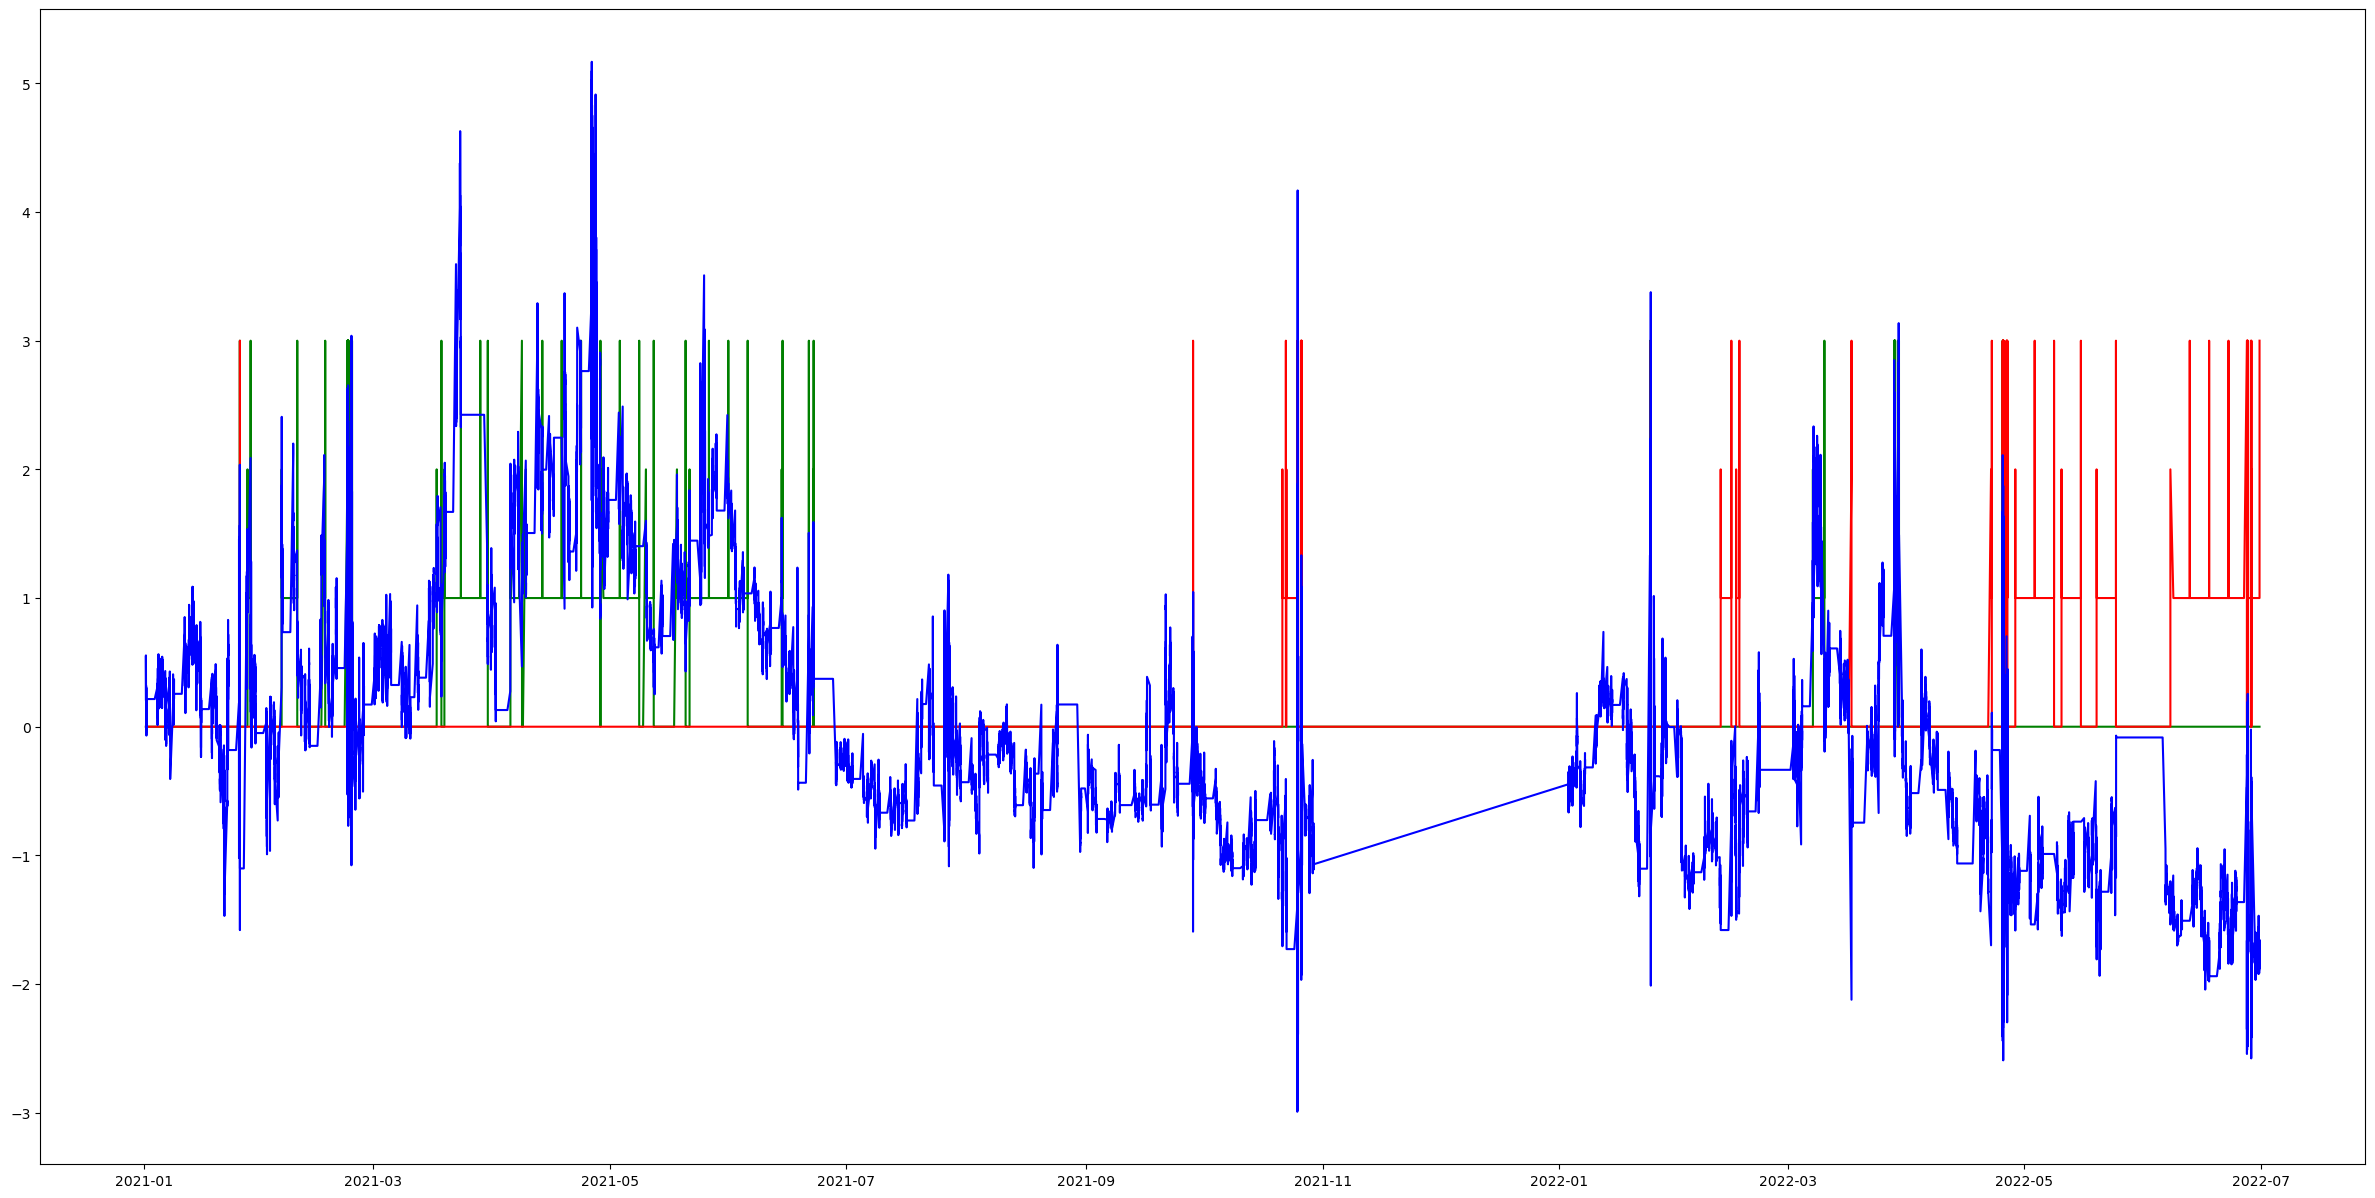

In [453]:
plt.figure(figsize=(30,15))
plt.plot(data_filled['signal_1'],'g')
plt.plot(data_filled['signal_2'],'r')
plt.plot(data_filled['z_score'],'b')

In [454]:
#Calculating P/L, when the signal is 2 it gives us the value when we entered the trade. 
#Similarly calculating P/L when the signal is 3 gives us the value when we exit the trade.
data_filled.insert(loc=7,column='P/L',value=0)
data_filled.loc[data_filled['signal_1']==2,'P/L']=data_filled['spread']*(data_filled['tte'])**0.7
data_filled.loc[data_filled['signal_1']==3,'P/L']=data_filled['spread']*(data_filled['tte'])**0.7
data_filled.loc[data_filled['signal_2']==2,'P/L']=data_filled['spread']*(data_filled['tte'])**0.7
data_filled.loc[data_filled['signal_2']==3,'P/L']=data_filled['spread']*(data_filled['tte'])**0.7
data_filled

,banknifty,nifty,tte,spread,z_score,signal_1,signal_2,P/L
time,,,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,0.543747,0,0,0.000000
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,0.491736,0,0,0.000000
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,0.464628,0,0,0.000000
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.540526,0,0,0.000000
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.553505,0,0,0.000000
...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,-1.731344,0,1,0.000000
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,-1.792623,0,1,0.000000
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,-1.754778,0,1,0.000000


In [455]:
count_Entry_1 = data_filled['signal_1'].value_counts()[2]
count_Exit_1 = data_filled['signal_1'].value_counts()[3]

count_Entry_2 = data_filled['signal_2'].value_counts()[2]
count_Exit_2 = data_filled['signal_2'].value_counts()[3]

print(count_Entry_1,count_Exit_1,count_Entry_2,count_Exit_2)


140 140 63 63


In [456]:
entry_1=data_filled.loc[data_filled['signal_1']==2,'P/L'].sum()
exit_1=data_filled.loc[data_filled['signal_1']==3,'P/L'].sum()
#this is shorting the spread hence entry - exit
return_1=(entry_1-exit_1)
print(return_1)

68.32293270103932


In [457]:
entry_2=data_filled.loc[data_filled['signal_2']==2,'P/L'].sum()
exit_2=data_filled.loc[data_filled['signal_2']==3,'P/L'].sum()
#this is long on the spread hence exit - entry
return_2=(exit_2-entry_2)
print(return_2)


28.1648513583442


In [458]:
# This is a important value which can be used to compare various models as we move ahead//
# which is P/L differnce per trade
total_trades = count_Entry_1 + count_Entry_2
avg_pnl = (return_1 + return_2)/total_trades # Average PNL
avg_pnl

0.475309281080707

In [459]:
returns = []
for i in range(len(data_filled)):
    if data_filled.iloc[i,5]==2:
        ent = data_filled.iloc[i,7]
        count = 1
        while data_filled.iloc[i+count,5]!=3 and count<1805:
            count+=1
        ext = data_filled.iloc[i+count,7]
        returns.append(ent-ext)
    if data_filled.iloc[i,6]==2:
        ent = data_filled.iloc[i,7]
        count = 1
        while data_filled.iloc[i+count,6]!=3:
            count+=1
        ext = data_filled.iloc[i+count,7]
        returns.append(ext-ent)
returns

[-0.5855871365968649,
 -0.5158465737377391,
 0.08839000088879928,
 -0.5855370508365099,
 0.5378109811907935,
 0.33870587551026576,
 0.34701439580358584,
 0.17958965680971595,
 1.113265874599553,
 0.6874048574822671,
 1.4400331530884158,
 0.13777257769957774,
 0.555398870266965,
 0.3288586708325564,
 0.11491638701680679,
 0.30618639356481503,
 0.5968706590417309,
 0.38242455382578966,
 0.3895615078705402,
 0.6130034946963757,
 0.6164945164035367,
 1.384885819687211,
 0.11922525256891608,
 0.3349278480318514,
 1.087106362851763,
 1.1416156333789045,
 -0.529473781251687,
 -0.5470986887164233,
 0.6664144670591803,
 0.637667480069628,
 1.316439448878122,
 0.5884224971608512,
 1.2272378164979982,
 -0.5955933685298067,
 0.5117362025761367,
 0.5590669326946148,
 0.7141054520442067,
 0.7465257130436466,
 0.8069108822967741,
 1.5177789087541451,
 0.14326426541691648,
 0.41635920246846003,
 1.3684150446175094,
 1.3444169113894566,
 0.6861459507720078,
 0.6310542163952081,
 0.7131646372653709,
 0.

In [460]:
returns_a = np.array(returns)
sharpe_ratio = (returns_a.mean()-.106)/returns_a.std()
sharpe_ratio

0.8870255847480466

### The above sharp_ratio we calculated is not really same as the traditional one, but to compare across models we can take it as an good proxy.

In [461]:
def max_drawdown(returns):
    cumulative_returns = np.cumprod(1 + returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = np.abs(np.min(drawdown))
    return max_drawdown

In [462]:
maximum_drawdown = max_drawdown(returns_a)
print("Maximum Drawdown:", maximum_drawdown)

Maximum Drawdown: 0.8609783082072809


## To generate a robus pairs trading strategy there are various approaches that we have and we can build complex models to incorporate each approach.
## Every approach has a goal of simplying some of the statistical variations and give efficient results, based on my readings and thoeries that I learnt, in my first approach I have tried to move towards the following goal:

#### Note: One of the very first paper in pairs trading strategy was given by Christopher Krauss that depicts various forms of pair trading strategies: Can be refered at: https://www.econstor.eu/bitstream/10419/116783/1/833997289.pdf

## Goal --> Stabilise Spread

### Z-Score Strategy,
$$(\text{BankNifty - Nifty}) \sim \text{f(Nifty)} = \alpha + (\beta - 1) \text{nifty} + \mu $$
#### Mean(Spread) is not constant for all observations but depends on the variable Nifty
### New Strategy,
$$\text{Spread} = (\text{BankNifty} - \beta.\text{Nifty}) - \alpha = \mu$$
$$\text{Mean(Spread)} = 0 ; \text{Var(Spread)} = \sigma^2$$
### Assumption -> $E[\mu]=0$ (from normal equations of OLS)
#### A good estimator for $\mu \sim \hat{\mu}$(residual)


### Here stablising means that we want a spread that has its parameters constant over time, which can help us predict them correctly but also we can also incorporate our mean diversion strategy with more accuracy

## Approach 1 - Regression model without train/test spilt with some issues

In [463]:
data_model=pd.read_parquet("data.parquet")
data_model = data_model.between_time('09:15', '15:30').copy()
missing_values = data.isnull().sum()
if missing_values.sum() > 0:
    data_m1 = data_model.fillna(method='ffill')
else:
    data_m1 = data_model
data_m1

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28


In [464]:
# Add a constant term to the independent variable (x)
x_with_const = sm.add_constant(data_m1['nifty'])

# Fit the linear regression model
model = sm.OLS(data_m1['banknifty'], x_with_const).fit()

# Get the predicted values (fitted values)
predicted_values = model.predict(x_with_const)

# Calculate residuals
data_m1['residuals'] = data_m1['banknifty'] - predicted_values

data_m1

,banknifty,nifty,tte,residuals
time,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.011898
2021-01-01 09:16:00,0.285381,0.200433,27,0.010425
2021-01-01 09:17:00,0.284233,0.200004,27,0.009762
2021-01-01 09:18:00,0.286104,0.199860,27,0.011796
2021-01-01 09:19:00,0.285539,0.198951,27,0.012260
...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.050471
2022-06-30 15:27:00,0.240875,0.216558,28,-0.052335
2022-06-30 15:28:00,0.242115,0.216794,28,-0.051362


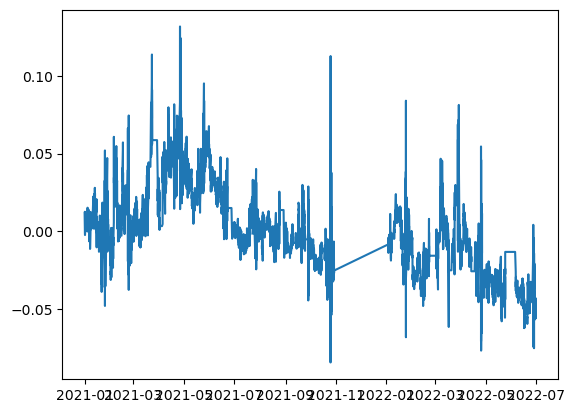

In [465]:
plt.plot(data_m1['residuals'])

,banknifty,nifty,tte,residuals,z_score
time,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.011898,0.460698
2021-01-01 09:16:00,0.285381,0.200433,27,0.010425,0.403650
2021-01-01 09:17:00,0.284233,0.200004,27,0.009762,0.377982
2021-01-01 09:18:00,0.286104,0.199860,27,0.011796,0.456718
2021-01-01 09:19:00,0.285539,0.198951,27,0.012260,0.474702
...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.050471,-1.954218
2022-06-30 15:27:00,0.240875,0.216558,28,-0.052335,-2.026396
2022-06-30 15:28:00,0.242115,0.216794,28,-0.051362,-1.988704


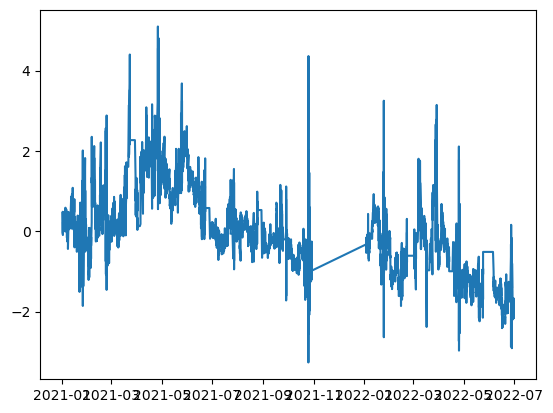

In [466]:
data_m1['z_score'] = zscore(data_m1['residuals'])
plt.plot(data_m1['z_score'])
data_m1

In [467]:
data_m1.insert(loc=5,column='signal_1',value=0)
data_m1.insert(loc=6,column='signal_2',value=0)


i=0
while i<len(data_m1)-30:
    #print(i)
    count=1
    if data_m1.iloc[i,4]>=1.5:
        data_m1.iloc[i,5]=2
        while ((i+count)<(len(data_m1)-1) and data_m1.iloc[i+count,4]>=0.5 and count<=1875):
            #print(count)
            data_m1.iloc[i+count,5]=1
            count=count+1
        data_m1.iloc[(i+count),5]=3
    if count>1875:
        i = i+count+1
    else:
        i=i+count

i=0
while i<len(data_m1)-30:
    #print(i)
    count=1
    if data_m1.iloc[i,4]<=-1.5:
        data_m1.iloc[i,6]=2
        while ((i+count)<(len(data_m1)-1) and data_m1.iloc[i+count,4]<=-0.5 and count<=1875):
            #print(count)
            data_m1.iloc[i+count,6]=1
            count=count+1
        data_m1.iloc[(i+count),6]=3
        
    if count>1875:
        i = i+count+1
    else:
        i=i+count


data_m1

,banknifty,nifty,tte,residuals,z_score,signal_1,signal_2
time,,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.011898,0.460698,0,0
2021-01-01 09:16:00,0.285381,0.200433,27,0.010425,0.403650,0,0
2021-01-01 09:17:00,0.284233,0.200004,27,0.009762,0.377982,0,0
2021-01-01 09:18:00,0.286104,0.199860,27,0.011796,0.456718,0,0
2021-01-01 09:19:00,0.285539,0.198951,27,0.012260,0.474702,0,0
...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.050471,-1.954218,0,1
2022-06-30 15:27:00,0.240875,0.216558,28,-0.052335,-2.026396,0,1
2022-06-30 15:28:00,0.242115,0.216794,28,-0.051362,-1.988704,0,1


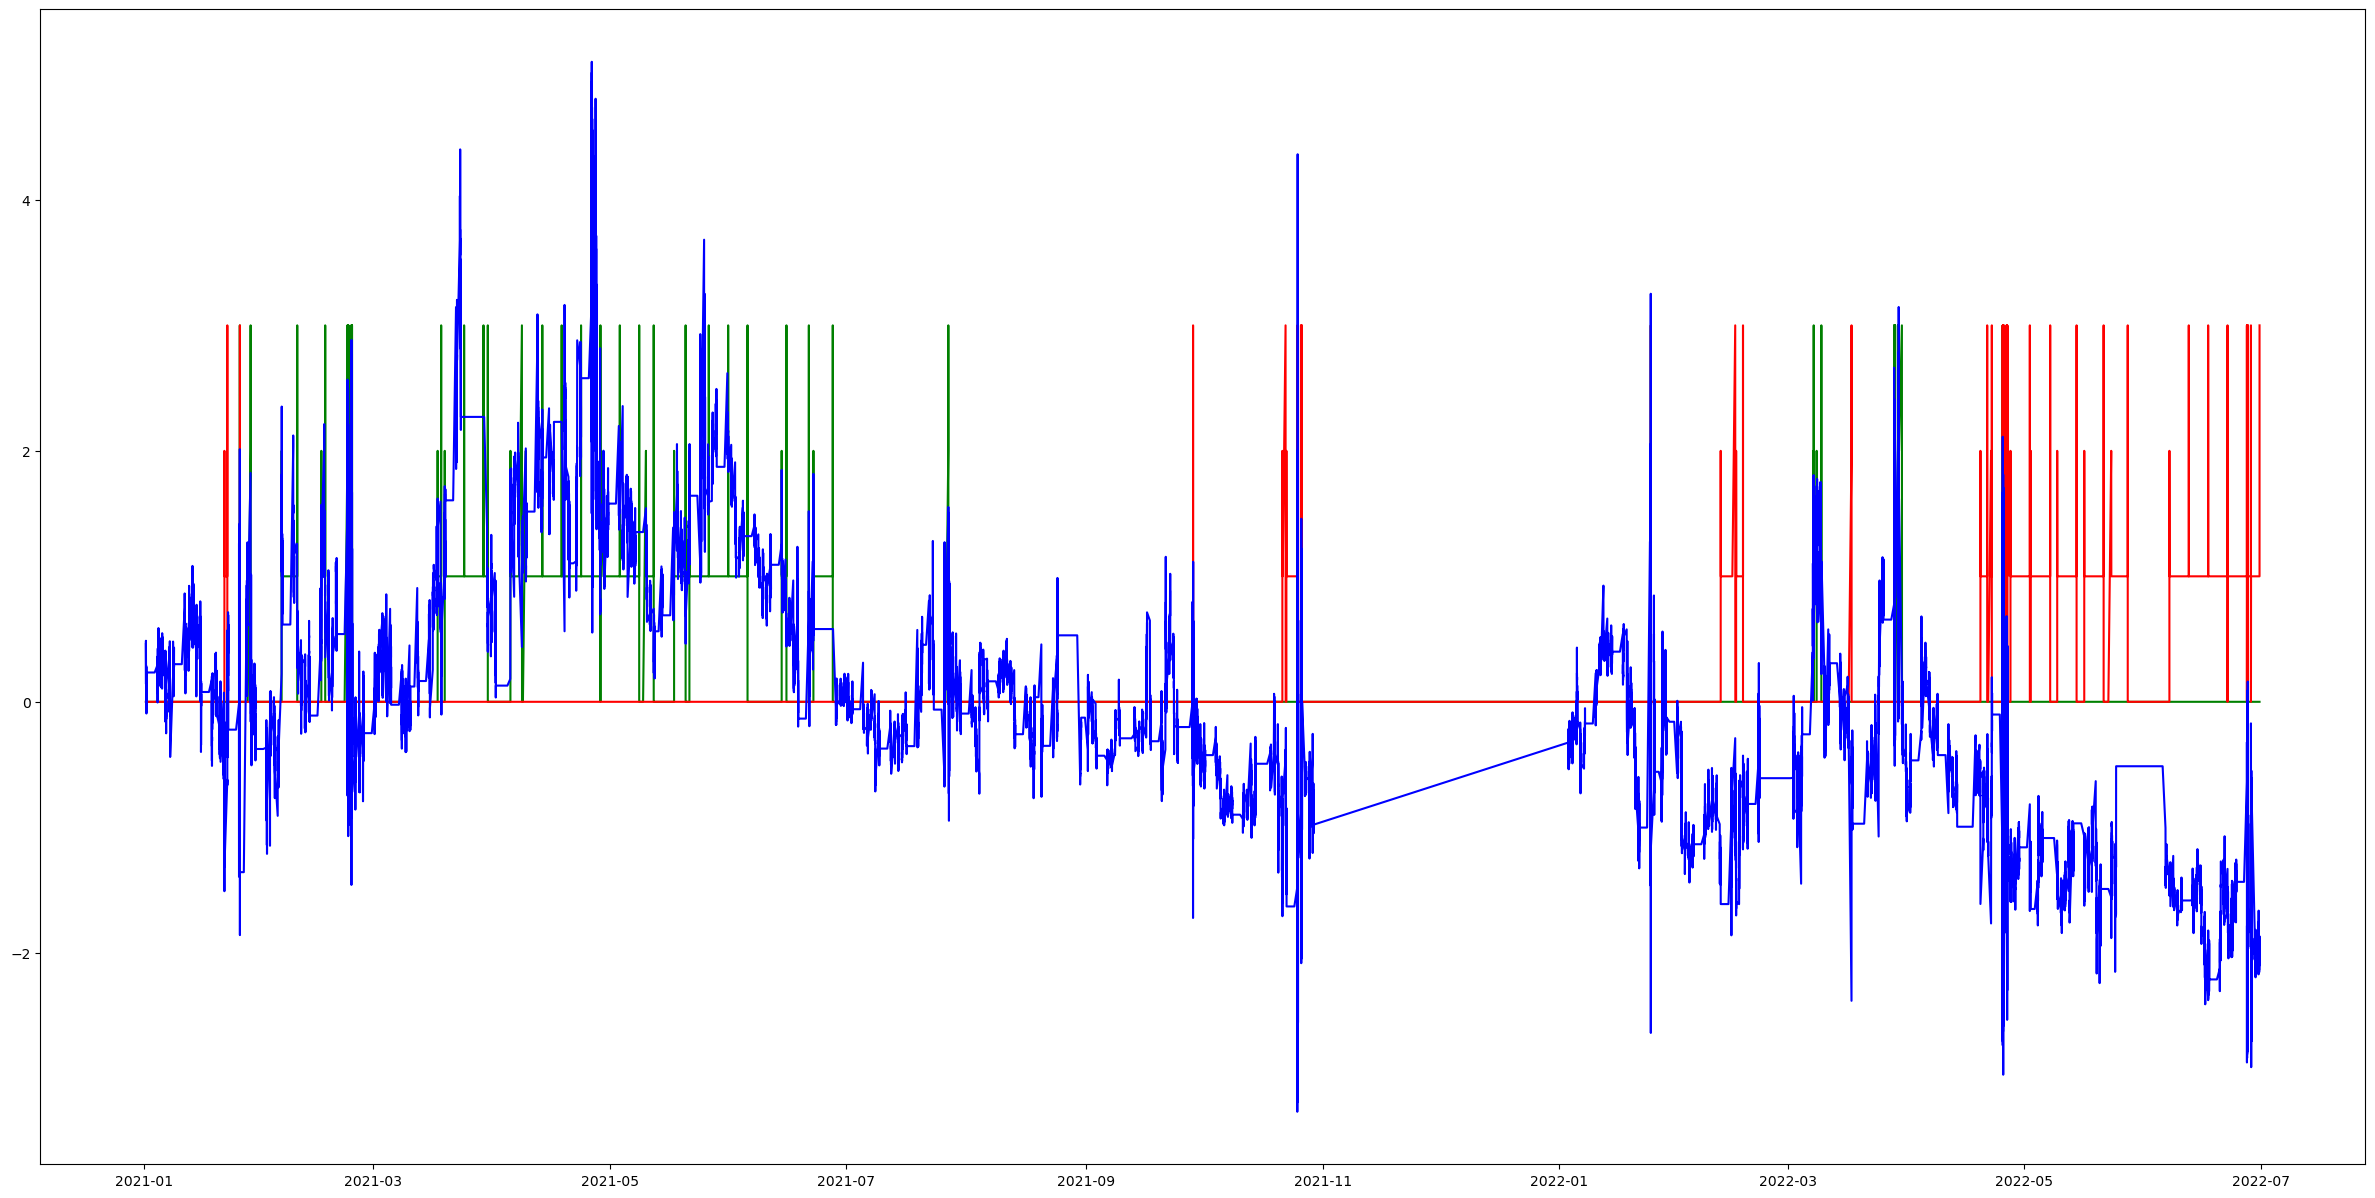

In [468]:
# the regions where we will trade
plt.figure(figsize=(30,15))
plt.plot(data_m1['signal_1'],'g')
plt.plot(data_m1['signal_2'],'r')
plt.plot(data_m1['z_score'],'b')

In [469]:
data_m1.insert(loc=7,column='P/L',value=0)
data_m1.loc[data_m1['signal_1']==2,'P/L']=data_m1['residuals']*(data_filled['tte'])**0.7
data_m1.loc[data_m1['signal_1']==3,'P/L']=data_m1['residuals']*(data_filled['tte'])**0.7
data_m1.loc[data_m1['signal_2']==2,'P/L']=data_m1['residuals']*(data_filled['tte'])**0.7
data_m1.loc[data_m1['signal_2']==3,'P/L']=data_m1['residuals']*(data_filled['tte'])**0.7
data_m1

,banknifty,nifty,tte,residuals,z_score,signal_1,signal_2,P/L
time,,,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.011898,0.460698,0,0,0.000000
2021-01-01 09:16:00,0.285381,0.200433,27,0.010425,0.403650,0,0,0.000000
2021-01-01 09:17:00,0.284233,0.200004,27,0.009762,0.377982,0,0,0.000000
2021-01-01 09:18:00,0.286104,0.199860,27,0.011796,0.456718,0,0,0.000000
2021-01-01 09:19:00,0.285539,0.198951,27,0.012260,0.474702,0,0,0.000000
...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.050471,-1.954218,0,1,0.000000
2022-06-30 15:27:00,0.240875,0.216558,28,-0.052335,-2.026396,0,1,0.000000
2022-06-30 15:28:00,0.242115,0.216794,28,-0.051362,-1.988704,0,1,0.000000


In [470]:
# no of trades in long and short
count_Entry_1 = data_m1['signal_1'].value_counts()[2]
count_Exit_1 = data_m1['signal_1'].value_counts()[3]

count_Entry_2 = data_m1['signal_2'].value_counts()[2]
count_Exit_2 = data_m1['signal_2'].value_counts()[3]

print(count_Entry_1,count_Exit_1,count_Entry_2,count_Exit_2)

140 140 69 69


In [471]:
entry_1=data_m1.loc[data_m1['signal_1']==2,'P/L'].sum()
exit_1=data_m1.loc[data_m1['signal_1']==3,'P/L'].sum()
#this is shorting the spread hence entry - exit
return_1=(entry_1-exit_1)
print(return_1)

62.463256359552254


In [472]:
entry_2=data_m1.loc[data_m1['signal_2']==2,'P/L'].sum()
exit_2=data_m1.loc[data_m1['signal_2']==3,'P/L'].sum()
#this is long on the spread hence exit - entry
return_2=(exit_2-entry_2)
print(return_2)

11.736100490400085


In [473]:
total_trades = count_Entry_1 + count_Entry_2
avg_pnl = (return_1 + return_2)/total_trades # Average PNL
avg_pnl

0.35502084617202073

In [474]:
returns = []
for i in range(len(data_m1)):
    if data_m1.iloc[i,5]==2:
        ent = data_m1.iloc[i,7]
        count = 1
        while data_m1.iloc[i+count,5]!=3 and count<1805:
            count+=1
        ext = data_m1.iloc[i+count,7]
        returns.append(ent-ext)
    if data_m1.iloc[i,6]==2:
        ent = data_m1.iloc[i,7]
        count = 1
        while data_m1.iloc[i+count,6]!=3:
            count+=1
        ext = data_m1.iloc[i+count,7]
        returns.append(ext-ent)
returns

[0.11021368235823308,
 0.1362110265152794,
 0.1803655949951014,
 0.09228151704473779,
 0.5366017099152108,
 0.39860766955045823,
 0.24941388284216698,
 0.14873662358506107,
 0.447597828799206,
 0.5101661951433519,
 0.771737870053707,
 0.07673753359150637,
 0.5393149540182163,
 0.296708730067919,
 -0.025264018887740297,
 0.06022506729588353,
 0.0645133140790164,
 0.059735259379814845,
 0.5580922348955856,
 0.015926504085235715,
 0.5944868185917634,
 0.38866842890312603,
 0.5454618346693603,
 0.6183222978061838,
 0.7070915574029742,
 0.07671613927866894,
 0.6727473190221532,
 0.455474344190184,
 0.15994013071846674,
 0.13879848792400065,
 0.6664947930497085,
 0.6372709617709313,
 0.6232322516711426,
 0.5867502560853166,
 0.5328904180687668,
 0.09931710300022142,
 0.5119801014928306,
 0.558138072149602,
 0.7172541470907026,
 0.7457727952571434,
 0.8067831360562203,
 0.8117887348710224,
 0.1435361474225733,
 0.7789738025892373,
 0.6191233702200482,
 0.05769875861152586,
 0.6412537211797312

In [475]:
returns_a = np.array(returns)
sharpe_ratio = (returns_a.mean()-.106)/returns_a.std()
sharpe_ratio

1.001956128545334

In [476]:
def max_drawdown(returns):
    cumulative_returns = np.cumprod(1 + returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = np.abs(np.min(drawdown))
    return max_drawdown

maximum_drawdown = max_drawdown(returns_a)
print("Maximum Drawdown:", maximum_drawdown)

Maximum Drawdown: 0.041008985066407044


## Drawbacks and issues with the above model: 1) Linear Regression related issues like omitted variable bias, heteroskedasticity. 2) Here we run the regression on  the entire data and then get the parameter values, i.e at each time of trade we know the entire data which is not possible, hence let us try to address this basic issue in our next approach



# We will try to address some issues now that where in the above model and move little towards a real case scenario
## Approach 2 - Regression model with train/test spilt 


In [477]:
# Generating data and handling the missing values
data_3=pd.read_parquet("data.parquet")
data_3 = data_3.between_time('09:15', '15:30').copy()
missing_values = data.isnull().sum()
if missing_values.sum() > 0:
    data_reg = data_3.fillna(method='ffill')
else:
    data_reg = data_3
data_reg

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28


In [478]:
# Spilting the data into training data and testing data. 
# Reason: As at particular time of trade we don't know the future values, hence we first find parameters from //
# training data and then use them to produce signals on the test data.

train= data_reg.loc[:'2021-10-29 15:15:00'].copy()
test= data_reg.loc['2022-01-03 09:15:00':].copy()

#Rolling regression can also be used instead of spilting data

In [479]:
# Now we first run a regression on training data to get the coefficients, and use these in test data //
# to generate signals based on the z_score of spread calculated from this data on test data where spread is the resiudals.

# Note: Here there are lot of assumptions in linear regression we are taking and can create "biased" //
# or "inefficient" estimates of parameters


# Add a constant term to the independent variable (x)
x_with_const = sm.add_constant(train['nifty'])

# Fit the linear regression model
model = sm.OLS(train['banknifty'], x_with_const).fit()

params = model.params

# Also we will need mean and std of residuals here to use them in Z-score of test data

# Get the predicted values (fitted values)
predicted_values = model.predict(x_with_const)

# Calculate residuals
train['residuals'] = train['banknifty'] - predicted_values

In [480]:
# Storing the parameters we need:
residual_mean = train['residuals'].mean() 
residual_std = train['residuals'].std() 

#Regression parameters
params

const    0.023839
nifty    1.343353
dtype: float64

In [481]:
print(residual_mean, residual_std)

2.644109901253709e-14 0.02107601095205325


In [482]:
alpha = params.const
beta = params.nifty

In [483]:
# We have got our parameter from train data, let us calculate spread on test data with help of this parameters
# residual_spread = y - y_hat = banknifty - (aplha + beta*nifty)

test['residual_spread'] = test['banknifty'] - alpha - beta*test['nifty']
test

,banknifty,nifty,tte,residual_spread
time,,,,
2022-01-03 09:15:00,0.214152,0.154115,24,-0.016718
2022-01-03 09:16:00,0.214935,0.155385,24,-0.017641
2022-01-03 09:17:00,0.216027,0.154671,24,-0.015589
2022-01-03 09:18:00,0.213095,0.153413,24,-0.016831
2022-01-03 09:19:00,0.213160,0.153133,24,-0.016391
...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.071634
2022-06-30 15:27:00,0.240875,0.216558,28,-0.073879
2022-06-30 15:28:00,0.242115,0.216794,28,-0.072955


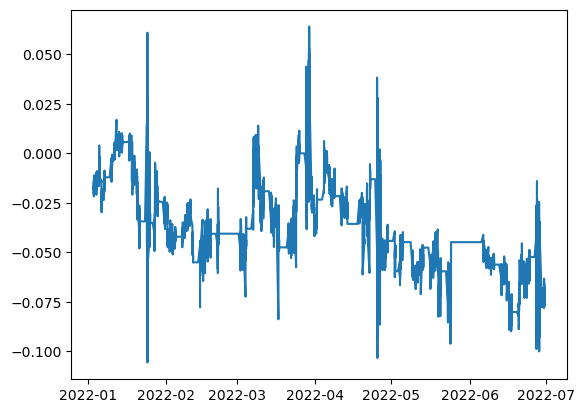

In [484]:
plt.plot(test['residual_spread'])

In [485]:
# CALCULATING Z-Score with help of mean and std from training dataset and residuals of test dataset //
# obtained with the help of "estimated" parameters from training dataset

test['Z_Score'] = (test['residual_spread'] - residual_mean)/residual_std
test

,banknifty,nifty,tte,residual_spread,Z_Score
time,,,,,
2022-01-03 09:15:00,0.214152,0.154115,24,-0.016718,-0.793202
2022-01-03 09:16:00,0.214935,0.155385,24,-0.017641,-0.837014
2022-01-03 09:17:00,0.216027,0.154671,24,-0.015589,-0.739677
2022-01-03 09:18:00,0.213095,0.153413,24,-0.016831,-0.798578
2022-01-03 09:19:00,0.213160,0.153133,24,-0.016391,-0.777726
...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.071634,-3.398840
2022-06-30 15:27:00,0.240875,0.216558,28,-0.073879,-3.505345
2022-06-30 15:28:00,0.242115,0.216794,28,-0.072955,-3.461513


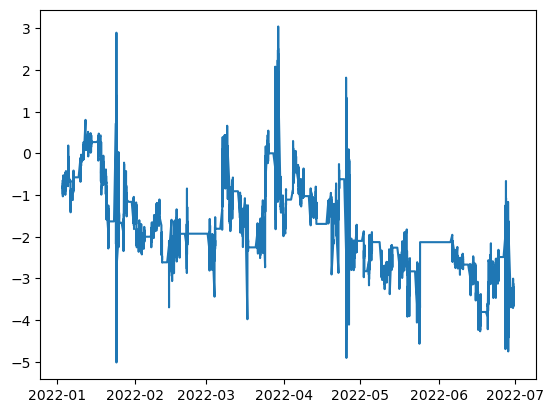

In [486]:
plt.plot(test['Z_Score'])

### In the above graph we can see and say that our spread or the zscore that we got is not stationary as we want because it is not as much oscilating around 0 and hence the mean or the parameters of it may be changing wrt time, and hence this method might not give accurate prediction about when to long or short the spread and hence we might need to imporve on this model maybe by calculating rolling z_score which updates it means periodically and also perform rolling regression that will update its parameter to give more stable residuals!

There are various other methods as well which can be used, for now let us proceed with this Z_score and will comeback later to other methods so that we can refine and generate more good trading signals

In [487]:
# Now we got our Z-scores for our resiudal spread we can decided the thhreshold to enter a trade and exit a trade.
# Here we assume that we can seprately place our long ansd short trade and if we are in a long or short trade //
# new trade of same type can only be initiated if we exit our first position.

# Before we decide on how are we trading let us create two columns in our test dataset, //
# One of us which will store the long positions and other short positions.

# Here it is important to understand the notion behind going long on spread and going short on spread, which //
# lies at heart of pair trading strategies


test.insert(loc=5,column='signal_1',value=0)
test.insert(loc=6,column='signal_2',value=0)


# Now let us understand some things on trades that we are entering and what assumptions we have made


### Here we decide our threshold for the diversion from mean based (Zscores) based on various factors.

### But For now let us ignore the factors and arbitarily take some values to enter a trade and exit a trade.

So when the Z-score is greater than 1.5 (assuming) we will enter a short the spread position that is we short the bank_nifty and go long on nifty and as soon as this falls again below 0.5 (assumption) we exit the trade. 
Theory lies at core of pairs trading startegy.

## Very Important point to note : We will also exit the trade if we are in the trade for more than 5 days i.e due to medium frequency startegy but in real case we may benefit from staying if the spread still has large deviation from mean.

Let us signal 2 if we are entering a trade as we get a signal and 3 when we exit, 1 is for when we are in the trade.
### Also when we see P/L it can be seen that we won't be in a long and short position simulteanously 




In [488]:
i=0
while i<len(test)-30:
    #print(i)
    count=1
    if test.iloc[i,4]>=1.5:
        test.iloc[i,5]=2
        while ((i+count)<(len(test)-1) and test.iloc[i+count,4]>=0.5 and count<=1875):
            #print(count)
            test.iloc[i+count,5]=1
            count=count+1
        test.iloc[(i+count),5]=3
    if count>1875:
        i = i+count+1
    else:
        i=i+count

i=0
while i<len(test)-30:
    #print(i)
    count=1
    if test.iloc[i,4]<=-1.5:
        test.iloc[i,6]=2
        while ((i+count)<(len(test)-1) and test.iloc[i+count,4]<=-0.5 and count<=1875):
            #print(count)
            test.iloc[i+count,6]=1
            count=count+1
        test.iloc[(i+count),6]=3
        
    if count>1875:
        i = i+count+1
    else:
        i=i+count


test

,banknifty,nifty,tte,residual_spread,Z_Score,signal_1,signal_2
time,,,,,,,
2022-01-03 09:15:00,0.214152,0.154115,24,-0.016718,-0.793202,0,0
2022-01-03 09:16:00,0.214935,0.155385,24,-0.017641,-0.837014,0,0
2022-01-03 09:17:00,0.216027,0.154671,24,-0.015589,-0.739677,0,0
2022-01-03 09:18:00,0.213095,0.153413,24,-0.016831,-0.798578,0,0
2022-01-03 09:19:00,0.213160,0.153133,24,-0.016391,-0.777726,0,0
...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.071634,-3.398840,0,1
2022-06-30 15:27:00,0.240875,0.216558,28,-0.073879,-3.505345,0,1
2022-06-30 15:28:00,0.242115,0.216794,28,-0.072955,-3.461513,0,1


### Also note we have decided the signals based on Zscore which are actually just taking into account the Z_Score at that time, there are various other startegies where we can build a momentum based startegy or some machine learning processes to create signals, for now let us proceed with this simple startegy and comeback later to other.

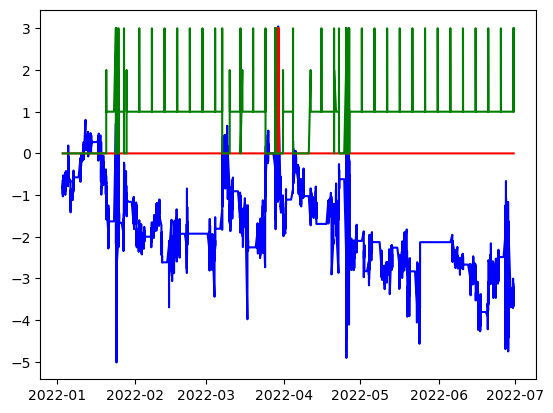

In [489]:
# SHOWS ARE WHAT TIME WE ARE ENTERING THE TRADE AND EXITING IN TRADE AND IF IT IS LONG/SHORT
plt.plot(test['Z_Score'],'b')
plt.plot(test['signal_1'],'r')
plt.plot(test['signal_2'],'g')

In [490]:
# let us also see number of trades we took for given time-period of test data
count_Entry_short = test['signal_1'].value_counts()[2]
count_Exit_short = test['signal_1'].value_counts()[3]

count_Entry_long = test['signal_2'].value_counts()[2]
count_Exit_long = test['signal_2'].value_counts()[3]

print(count_Entry_short,count_Exit_short,count_Entry_long,count_Exit_long)


45 45 80 80


In [491]:
# We calculate P/L for each entry and exit, and then for net P/L we take difference of both later depending on long/short.

test.insert(loc=7,column='P/L',value=0)
test.loc[test['signal_1']==2,'P/L']=test['residual_spread']*((test['tte'])**0.7)
test.loc[test['signal_2']==2,'P/L']=test['residual_spread']*((test['tte'])**0.7)
test.loc[test['signal_1']==3,'P/L']=test['residual_spread']*((test['tte'])**0.7)
test.loc[test['signal_2']==3,'P/L']=test['residual_spread']*((test['tte'])**0.7)
test

,banknifty,nifty,tte,residual_spread,Z_Score,signal_1,signal_2,P/L
time,,,,,,,,
2022-01-03 09:15:00,0.214152,0.154115,24,-0.016718,-0.793202,0,0,0.000000
2022-01-03 09:16:00,0.214935,0.155385,24,-0.017641,-0.837014,0,0,0.000000
2022-01-03 09:17:00,0.216027,0.154671,24,-0.015589,-0.739677,0,0,0.000000
2022-01-03 09:18:00,0.213095,0.153413,24,-0.016831,-0.798578,0,0,0.000000
2022-01-03 09:19:00,0.213160,0.153133,24,-0.016391,-0.777726,0,0,0.000000
...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.071634,-3.398840,0,1,0.000000
2022-06-30 15:27:00,0.240875,0.216558,28,-0.073879,-3.505345,0,1,0.000000
2022-06-30 15:28:00,0.242115,0.216794,28,-0.072955,-3.461513,0,1,0.000000


In [492]:
# Now let us calculate net_p/l first for both long and short positions:
entry_1=test.loc[test['signal_1']==2,'P/L'].sum()
exit_1=test.loc[test['signal_1']==3,'P/L'].sum()
#this is shorting the spread hence entry - exit
return_1=(entry_1-exit_1)
print(return_1)

entry_2=test.loc[test['signal_2']==2,'P/L'].sum()
exit_2=test.loc[test['signal_2']==3,'P/L'].sum()
#this is long on the spread hence exit - entry
return_2=(exit_2-entry_2)
print(return_2)


18.111464361587682
21.438647073326294


In [493]:
# Now for comparing let us calculate average P/L per trade so that we can compare with other strtagies
total_trades = count_Entry_long + count_Entry_short
avg_pnl = (return_1 + return_2)/total_trades # Average PNL
avg_pnl

0.3164008914793118

In [494]:
# We also for sharp ratio make a array and store returns for each trade executed separetely.

returns = []
for i in range(len(test)):
    if test.iloc[i,5]==2:
        ent = test.iloc[i,7]
        count = 1
        while test.iloc[i+count,5]!=3 and count<1805:
            count+=1
        ext = test.iloc[i+count,7]
        returns.append(ent-ext)
    if test.iloc[i,6]==2:
        ent = test.iloc[i,7]
        count = 1
        while test.iloc[i+count,6]!=3:
            count+=1
        ext = test.iloc[i+count,7]
        returns.append(ext-ent)
returns

[0.292813670307063,
 0.048934498318662506,
 0.1496209769903898,
 0.000309334923231111,
 0.18247885388061463,
 0.12952462535138448,
 0.14642059561259954,
 0.00907941894662423,
 0.7860536525267711,
 0.6941353866498912,
 0.39372139348336765,
 0.5621884450930188,
 0.17936465065294055,
 0.3131128969399916,
 0.449404685396288,
 0.1563595682490212,
 0.06526664840953458,
 0.26129424968799286,
 0.002299317323883665,
 0.03245549585182683,
 -0.061704188400687365,
 0.1713197427880271,
 0.07035478212000809,
 0.0,
 -0.3581660424582234,
 0.3214841978185152,
 0.08483975925265022,
 -0.05686256989234009,
 0.2607916752485757,
 0.36282952756375075,
 0.5532595536191105,
 0.7474035105270715,
 0.46908565161428867,
 0.4767111838642404,
 0.33635388277921974,
 0.33443526824853453,
 0.34731946513816947,
 0.3168264824102769,
 0.32533041255567313,
 0.32547659754060687,
 0.3352118359716426,
 0.2970345791371054,
 0.32486269052535005,
 0.3242420458788351,
 0.06370834014842773,
 0.2858151210980026,
 0.2762617706504738

In [495]:
returns_a = np.array(returns)
sharpe_ratio = (returns_a.mean()-.106)/returns_a.std()
sharpe_ratio

0.7472703197473319

In [496]:
# Calculating the maximum drawdown from an array of returns.
def max_drawdown(returns):
    cumulative_returns = np.cumprod(1 + returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = np.abs(np.min(drawdown))
    return max_drawdown

maximum_drawdown = max_drawdown(returns_a)
print("Maximum Drawdown:", maximum_drawdown)

Maximum Drawdown: 0.6728919276329763


## Approach 3 - Using a rolling regression model as mentioned in above model.

Lets hope we imporve our results!

In [497]:
# Define the window size for the rolling regression 
window_size = 60 # Example window size, adjust based on analysis needs 
# Initialize the series to store the rolling regression residuals 
rolling_residuals = pd.Series(index=data_m1.index) 
# Perform rolling regression and calculate residuals 
for start in range(len(data_filled) - window_size): 
    end = start + window_size 
    X = sm.add_constant(data_m1['nifty'][start:end]) 
    # Predictor variable with constant 
    y = data_m1['banknifty'][start:end] 
    # Response variable 
    model = OLS(y, X).fit() 
    predictions = model.predict(X) 
    residuals = y - predictions 
    rolling_residuals[end:end+1] = residuals.iloc[-1] 
    # Fill the initial part of the series where rolling residuals are not available with the first available residual 
    rolling_residuals = rolling_residuals.fillna(method='bfill') 
    # Update the dataset with the rolling residuals 
    data_m1['rolling_residual_spread'] = rolling_residuals 

/var/folders/p9/49qqydtn3lz94zb596f_slc40000gn/T/ipykernel_35863/1809743478.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rolling_residuals = pd.Series(index=data_m1.index)


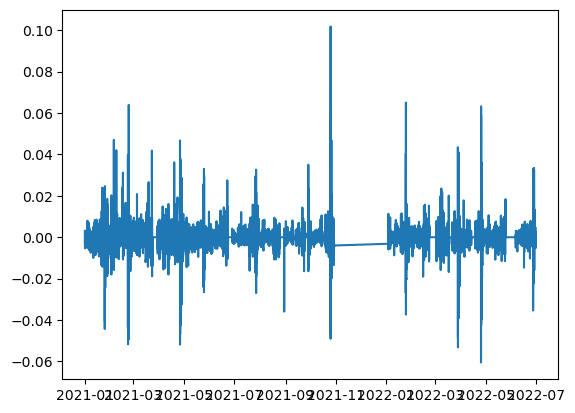

In [498]:
plt.plot(data_m1['rolling_residual_spread'])

In [499]:
data_m1['z_score_rolling'] = zscore(data_m1['rolling_residual_spread'])
data_m1

,banknifty,nifty,tte,residuals,z_score,signal_1,signal_2,P/L,rolling_residual_spread,z_score_rolling
time,,,,,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.011898,0.460698,0,0,0.000000,-0.002436,-0.644459
2021-01-01 09:16:00,0.285381,0.200433,27,0.010425,0.403650,0,0,0.000000,-0.002436,-0.644459
2021-01-01 09:17:00,0.284233,0.200004,27,0.009762,0.377982,0,0,0.000000,-0.002436,-0.644459
2021-01-01 09:18:00,0.286104,0.199860,27,0.011796,0.456718,0,0,0.000000,-0.002436,-0.644459
2021-01-01 09:19:00,0.285539,0.198951,27,0.012260,0.474702,0,0,0.000000,-0.002436,-0.644459
...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.050471,-1.954218,0,1,0.000000,0.000075,0.045701
2022-06-30 15:27:00,0.240875,0.216558,28,-0.052335,-2.026396,0,1,0.000000,0.001359,0.398508
2022-06-30 15:28:00,0.242115,0.216794,28,-0.051362,-1.988704,0,1,0.000000,0.000937,0.282519


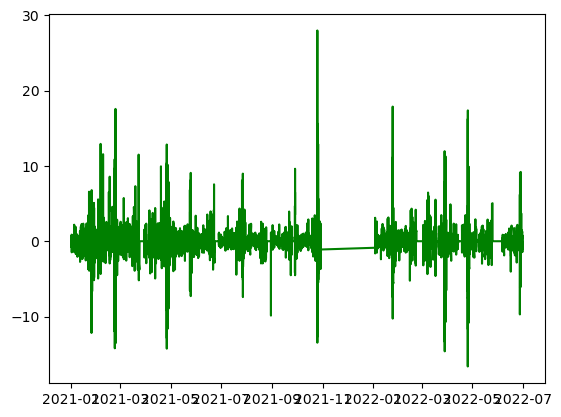

In [500]:
plt.plot(data_m1['z_score_rolling'],'g')

In [501]:
data_m1.insert(loc=10,column='signal_11',value=0)
data_m1.insert(loc=11,column='signal_22',value=0)


i=0
while i<len(data_m1)-30:
    #print(i)
    count=1
    if data_m1.iloc[i,9]>=1.5:
        data_m1.iloc[i,10]=2
        while ((i+count)<(len(data_m1)-1) and data_m1.iloc[i+count,9]>=0.5 and count<=1875):
            #print(count)
            data_m1.iloc[i+count,10]=1
            count=count+1
        data_m1.iloc[(i+count),10]=3
    if count>1875:
        i = i+count+1
    else:
        i=i+count

i=0
while i<len(data_m1)-30:
    #print(i)
    count=1
    if data_m1.iloc[i,9]<=-1.5:
        data_m1.iloc[i,11]=2
        while ((i+count)<(len(data_m1)-1) and data_m1.iloc[i+count,9]<=-0.5 and count<=1875):
            #print(count)
            data_m1.iloc[i+count,11]=1
            count=count+1
        data_m1.iloc[(i+count),11]=3
        
    if count>1875:
        i = i+count+1
    else:
        i=i+count


data_m1

,banknifty,nifty,tte,residuals,z_score,signal_1,signal_2,P/L,rolling_residual_spread,z_score_rolling,signal_11,signal_22
time,,,,,,,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.011898,0.460698,0,0,0.000000,-0.002436,-0.644459,0,0
2021-01-01 09:16:00,0.285381,0.200433,27,0.010425,0.403650,0,0,0.000000,-0.002436,-0.644459,0,0
2021-01-01 09:17:00,0.284233,0.200004,27,0.009762,0.377982,0,0,0.000000,-0.002436,-0.644459,0,0
2021-01-01 09:18:00,0.286104,0.199860,27,0.011796,0.456718,0,0,0.000000,-0.002436,-0.644459,0,0
2021-01-01 09:19:00,0.285539,0.198951,27,0.012260,0.474702,0,0,0.000000,-0.002436,-0.644459,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.050471,-1.954218,0,1,0.000000,0.000075,0.045701,0,0
2022-06-30 15:27:00,0.240875,0.216558,28,-0.052335,-2.026396,0,1,0.000000,0.001359,0.398508,0,0
2022-06-30 15:28:00,0.242115,0.216794,28,-0.051362,-1.988704,0,1,0.000000,0.000937,0.282519,0,0


In [502]:
count_Entry_11 = data_m1['signal_11'].value_counts()[2]
count_Exit_11 = data_m1['signal_11'].value_counts()[3]

count_Entry_22 = data_m1['signal_22'].value_counts()[2]
count_Exit_22 = data_m1['signal_22'].value_counts()[3]

print(count_Entry_1,count_Exit_1,count_Entry_2,count_Exit_2)


140 140 69 69


In [503]:
data_m1.insert(loc=12,column='P/L_2',value=0)
data_m1.loc[data_m1['signal_11']==2,'P/L_2']=data_m1['rolling_residual_spread']*(data_filled['tte'])**0.7
data_m1.loc[data_m1['signal_22']==2,'P/L_2']=data_m1['rolling_residual_spread']*(data_filled['tte'])**0.7
data_m1.loc[data_m1['signal_11']==3,'P/L_2']=data_m1['rolling_residual_spread']*(data_filled['tte'])**0.7
data_m1.loc[data_m1['signal_22']==3,'P/L_2']=data_m1['rolling_residual_spread']*(data_filled['tte'])**0.7
data_m1

,banknifty,nifty,tte,residuals,z_score,signal_1,signal_2,P/L,rolling_residual_spread,z_score_rolling,signal_11,signal_22,P/L_2
time,,,,,,,,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.011898,0.460698,0,0,0.000000,-0.002436,-0.644459,0,0,0.0
2021-01-01 09:16:00,0.285381,0.200433,27,0.010425,0.403650,0,0,0.000000,-0.002436,-0.644459,0,0,0.0
2021-01-01 09:17:00,0.284233,0.200004,27,0.009762,0.377982,0,0,0.000000,-0.002436,-0.644459,0,0,0.0
2021-01-01 09:18:00,0.286104,0.199860,27,0.011796,0.456718,0,0,0.000000,-0.002436,-0.644459,0,0,0.0
2021-01-01 09:19:00,0.285539,0.198951,27,0.012260,0.474702,0,0,0.000000,-0.002436,-0.644459,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.050471,-1.954218,0,1,0.000000,0.000075,0.045701,0,0,0.0
2022-06-30 15:27:00,0.240875,0.216558,28,-0.052335,-2.026396,0,1,0.000000,0.001359,0.398508,0,0,0.0
2022-06-30 15:28:00,0.242115,0.216794,28,-0.051362,-1.988704,0,1,0.000000,0.000937,0.282519,0,0,0.0


In [504]:
entry_1=data_m1.loc[data_m1['signal_11']==2,'P/L_2'].sum()
exit_1=data_m1.loc[data_m1['signal_11']==3,'P/L_2'].sum()
#this is shorting the spread hence entry - exit
return_1=(entry_1-exit_1)
print(return_1)

entry_2=data_m1.loc[data_m1['signal_22']==2,'P/L_2'].sum()
exit_2=data_m1.loc[data_m1['signal_22']==3,'P/L_2'].sum()
#this is long on the spread hence exit - entry
return_2=(exit_2-entry_2)
print(return_2)

total_trades = count_Entry_1 + count_Entry_2
avg_pnl = (return_1 + return_2)/total_trades # Average PNL
avg_pnl

194.81560556028813
188.6841822646004


1.8349272144731508

In [505]:
returns = []
for i in range(len(data_m1)):
    if data_m1.iloc[i,10]==2:
        ent = data_m1.iloc[i,12]
        count = 1
        while data_m1.iloc[i+count,10]!=3 and count<1805:
            count+=1
        ext = data_m1.iloc[i+count,12]
        returns.append(ent-ext)
    if data_m1.iloc[i,11]==2:
        ent = data_m1.iloc[i,12]
        count = 1
        while data_m1.iloc[i+count,11]!=3:
            count+=1
        ext = data_m1.iloc[i+count,12]
        returns.append(ext-ent)
returns

returns_a = np.array(returns)
sharpe_ratio = (returns_a.mean()-.106)/returns_a.std()
print(sharpe_ratio)

def max_drawdown(returns):
    """
    Calculate the maximum drawdown from an array of returns.

    Parameters:
    returns (np.array): Array of returns.

    Returns:
    float: Maximum drawdown.
    """
    cumulative_returns = np.cumprod(1 + returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = np.abs(np.min(drawdown))
    return max_drawdown

maximum_drawdown = max_drawdown(returns_a)
print("Maximum Drawdown:", maximum_drawdown)

0.33062125621509325
Maximum Drawdown: 0.008418233144454487


### Comparing the results:

## 1) Base Model
### Average P/L = 0.4753, Sharpe Ratio = 0.8870, Max_drawdown = 0.86


## 2) Simple Linear Regression - on entire dataset
### Average P/L = 0.355, Sharpe Ratio = 1.001, Max_drawdown = 0.04

## 3) Simple Linear Regression - with train/test split
### Average P/L = 0.31, Sharpe Ratio = 0.74, Max_drawdown = 0.67

## 4) Rolling Regression
### Average P/L = 1.83, Sharpe Ratio = 0.33, Max_drawdown = 0.008

# Other Approaches and Conclusions

### There are many other improvements in above 3 approaches that can be done and many different models that can be implemented.

## If we try to break pairs trading as a whole into steps and then modify processes at each step that will optimize the results that we want, it can result into a robust strategy.
### Though here we have not done optimization, it can be done by backtesting for several choice parameters.

### Below I have specefied two approach or slight changes that can be brought in to produce some more efficient signals. Comparsion with above is not possible with the following models as they are based on various simplying assumptions. Important thing to note is the Mathematical approach behind one approach (Principal Component Analysis) and other one is based on changing the way we create signals which is based on a momentum startegy (RSI)

## PCA Approach

In [506]:
data_4=pd.read_parquet("data.parquet")
data_4 = data_4.between_time('09:15', '15:30').copy()
missing_values = data_4.isnull().sum()
if missing_values.sum() > 0:
    data_pca = data_4.fillna(method='ffill')
else:
    data_pca = data_4
data_pca

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28


In [507]:
# To apply PCA first we bring down both to same scale i.e normalise the data

# Calculate the IV spread between Bank Nifty and Nifty _ we are taking spread for test data by same logic //
# we used earlier and using the resiudal spread instead of normal spread.

train_pca= data_pca.loc[:'2021-10-29 15:15:00'].copy()
test_pca= data_pca.loc['2022-01-03 09:15:00':].copy()

import statsmodels.api as sm

# Add a constant term to the independent variable (x)
x_with_const = sm.add_constant(train_pca['nifty'])

# Fit the linear regression model
model = sm.OLS(train_pca['banknifty'], x_with_const).fit()

params = model.params

alpha = params.const
beta = params.nifty

test_pca['residual_spread'] = test_pca['banknifty'] - alpha - beta*test_pca['nifty']
test_pca

,banknifty,nifty,tte,residual_spread
time,,,,
2022-01-03 09:15:00,0.214152,0.154115,24,-0.016718
2022-01-03 09:16:00,0.214935,0.155385,24,-0.017641
2022-01-03 09:17:00,0.216027,0.154671,24,-0.015589
2022-01-03 09:18:00,0.213095,0.153413,24,-0.016831
2022-01-03 09:19:00,0.213160,0.153133,24,-0.016391
...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.071634
2022-06-30 15:27:00,0.240875,0.216558,28,-0.073879
2022-06-30 15:28:00,0.242115,0.216794,28,-0.072955


In [508]:
# Standardize the IV Spread for PCA
scaler = StandardScaler()
iv_spread_scaled = scaler.fit_transform(test_pca[['residual_spread']])

In [509]:
# Apply PCA to the scaled IV Spread
pca = PCA(n_components=1)  # Using 1 component since we're focusing on the IV spread
pca.fit(iv_spread_scaled)

PCA(n_components=1)

In [510]:
# Transform the IV spread data to the principal component space
iv_spread_pca = pca.transform(iv_spread_scaled)

In [511]:
# Add the principal component scores to the dataframe
test_pca['iv_spread_pc1'] = iv_spread_pca[:, 0]
test_pca

,banknifty,nifty,tte,residual_spread,iv_spread_pc1
time,,,,,
2022-01-03 09:15:00,0.214152,0.154115,24,-0.016718,1.007766
2022-01-03 09:16:00,0.214935,0.155385,24,-0.017641,0.962817
2022-01-03 09:17:00,0.216027,0.154671,24,-0.015589,1.062680
2022-01-03 09:18:00,0.213095,0.153413,24,-0.016831,1.002251
2022-01-03 09:19:00,0.213160,0.153133,24,-0.016391,1.023643
...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.071634,-1.665481
2022-06-30 15:27:00,0.240875,0.216558,28,-0.073879,-1.774750
2022-06-30 15:28:00,0.242115,0.216794,28,-0.072955,-1.729780


In [512]:
### Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_

### Now, let's prepare to generate trading signals based on the first principal component
### A simple strategy: Buy (1) when the score of PC1 increases, Sell (-1) when it decreases
test_pca['signal'] = test_pca['iv_spread_pc1'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

In [513]:
# Calculate the P/L for trading signals, assuming 'tte' is the time to expiry
# P/L = Spread * (TTE)^0.7 for trades
# Note: This simplistic model does not account for bid-ask spread, transaction costs, or slippage
test_pca['P/L'] = test_pca.apply(lambda row: row['residual_spread'] * (row['tte'] ** 0.7) if row['signal'] != 0 else 0, axis=1)
test_pca

,banknifty,nifty,tte,residual_spread,iv_spread_pc1,signal,P/L
time,,,,,,,
2022-01-03 09:15:00,0.214152,0.154115,24,-0.016718,1.007766,0,0.000000
2022-01-03 09:16:00,0.214935,0.155385,24,-0.017641,0.962817,-1,-0.163181
2022-01-03 09:17:00,0.216027,0.154671,24,-0.015589,1.062680,1,-0.144204
2022-01-03 09:18:00,0.213095,0.153413,24,-0.016831,1.002251,-1,-0.155687
2022-01-03 09:19:00,0.213160,0.153133,24,-0.016391,1.023643,1,-0.151622
...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.071634,-1.665481,1,-0.738125
2022-06-30 15:27:00,0.240875,0.216558,28,-0.073879,-1.774750,-1,-0.761254
2022-06-30 15:28:00,0.242115,0.216794,28,-0.072955,-1.729780,1,-0.751735


In [514]:
# First let us see how many times we have gone long and how many times short:
print(test_pca['signal'].value_counts()[1])
print(test_pca['signal'].value_counts()[-1])

20467
20517


In [515]:
# Calculate cumulative P/L as +1 in buying -1 is selling and we are ignoring the closing of trades here
# So net P/L or the total P/L will be +1 x P/L + -1 x P/L
long_net_P_L= test_pca.loc[test_pca['signal']==1,'P/L'].sum()

short_net_P_L=test_pca.loc[test_pca['signal']==-1,'P/L'].sum()

#this is long on the spread hence exit - entry
Net_PL = long_net_P_L - short_net_P_L
print(Net_PL)

191.07101378136394


### In the above case main aim is to show how PCA can be used to generate signals rather than comparing it to our base model. We are ignoring the closing of trades here and assuming that we can long and short as much as we can and netPL is calulated which will differ in real case beacause positions need to be closed.

## Also we have directly performed the PCA analysis with help of libaries but the underlying maths is as follows:

### In short we are identfying major factors that are affecting our spread (Bank nifty - Nifty), and by analysing them we are creating signals. Reason to use is to reduce the complexity of data.

#### The method to calculate this component is based on matrix algebra, for reference:
#### Link:https://builtin.com/data-science/step-step-explanation-principal-component-analysis


# Now let us refine our approach of generating signals by the Z-Scores
### We will use a momentum indicator generally used to asses price, but we also can asses Z-scores obtained with it, which is RSI (Relative Strength Index).

RSI here - measures the speed and change of Z-score, it tells how significantly spread deviates from its mean.

In short we are checking with RSI if Z-score is peaking or botoming out, which then will potentially signal a reversal!!


In [516]:
# Function to calculate RSI 
def rsi(series, period=14): 
    delta = series.diff() 
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean() 
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean() 
    rs = gain / loss 
    return 100 - (100 / (1 + rs)) 

test['z_score_rsi'] = rsi(test['Z_Score'], period=14) 
test

,banknifty,nifty,tte,residual_spread,Z_Score,signal_1,signal_2,P/L,z_score_rsi
time,,,,,,,,,
2022-01-03 09:15:00,0.214152,0.154115,24,-0.016718,-0.793202,0,0,0.000000,NaN
2022-01-03 09:16:00,0.214935,0.155385,24,-0.017641,-0.837014,0,0,0.000000,NaN
2022-01-03 09:17:00,0.216027,0.154671,24,-0.015589,-0.739677,0,0,0.000000,NaN
2022-01-03 09:18:00,0.213095,0.153413,24,-0.016831,-0.798578,0,0,0.000000,NaN
2022-01-03 09:19:00,0.213160,0.153133,24,-0.016391,-0.777726,0,0,0.000000,NaN
...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.071634,-3.398840,0,1,0.000000,38.888562
2022-06-30 15:27:00,0.240875,0.216558,28,-0.073879,-3.505345,0,1,0.000000,27.856993
2022-06-30 15:28:00,0.242115,0.216794,28,-0.072955,-3.461513,0,1,0.000000,34.453931


In [517]:
# Handling some null values generated due to rolling nature of rsi:

test['z_score_rsi'] = test['z_score_rsi'].fillna(method='bfill')
test

,banknifty,nifty,tte,residual_spread,Z_Score,signal_1,signal_2,P/L,z_score_rsi
time,,,,,,,,,
2022-01-03 09:15:00,0.214152,0.154115,24,-0.016718,-0.793202,0,0,0.000000,55.743394
2022-01-03 09:16:00,0.214935,0.155385,24,-0.017641,-0.837014,0,0,0.000000,55.743394
2022-01-03 09:17:00,0.216027,0.154671,24,-0.015589,-0.739677,0,0,0.000000,55.743394
2022-01-03 09:18:00,0.213095,0.153413,24,-0.016831,-0.798578,0,0,0.000000,55.743394
2022-01-03 09:19:00,0.213160,0.153133,24,-0.016391,-0.777726,0,0,0.000000,55.743394
...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.071634,-3.398840,0,1,0.000000,38.888562
2022-06-30 15:27:00,0.240875,0.216558,28,-0.073879,-3.505345,0,1,0.000000,27.856993
2022-06-30 15:28:00,0.242115,0.216794,28,-0.072955,-3.461513,0,1,0.000000,34.453931


In [518]:
test['z_score_rsi'].describe()

count    67304.000000
mean        51.699664
std         32.375847
min          0.000000
25%         36.892555
50%         50.628295
75%         67.321999
max        100.000000
Name: z_score_rsi, dtype: float64

In [519]:
test['long_signal_rsi'] = 0

In [520]:
#Example of generating a Long trading signal
i = 0
while i < len(test)-30:
    count = 1
    if test.iloc[i,8] <= 30 :
        test.iloc[i,9] = 2  # Enter long trade
        while (i + count) < len(test)-1 and test.iloc[i + count,8] <= 45 and count <= 1875:
            test.iloc[i + count,9] = 1  # Stay in long trade
            count += 1
        test.iloc[i + count,9] = 3  # Exit long trade
    if count>1875:
        i = i+count+1
    else:
        i=i+count

In [521]:
test['long_signal_rsi'].describe()

count    67304.000000
mean         0.268780
std          0.515596
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: long_signal_rsi, dtype: float64

In [522]:
count_Entry_long_rsi = test['long_signal_rsi'].value_counts()[2]
count_Exit_long_rsi = test['long_signal_rsi'].value_counts()[3]
print(count_Entry_long_rsi,count_Exit_long_rsi)

583 583


In [523]:
# We calculate P/L for each entry and exit for long trades

test.insert(loc=9,column='P/L_rsi_long',value=0)
test.loc[test['long_signal_rsi']==3,'P/L_rsi']=test['residual_spread']*((test['tte'])**0.7)
test.loc[test['long_signal_rsi']==3,'P/L_rsi']=test['residual_spread']*((test['tte'])**0.7)
test

,banknifty,nifty,tte,residual_spread,Z_Score,signal_1,signal_2,P/L,z_score_rsi,P/L_rsi_long,long_signal_rsi,P/L_rsi
time,,,,,,,,,,,,
2022-01-03 09:15:00,0.214152,0.154115,24,-0.016718,-0.793202,0,0,0.000000,55.743394,0,0,NaN
2022-01-03 09:16:00,0.214935,0.155385,24,-0.017641,-0.837014,0,0,0.000000,55.743394,0,0,NaN
2022-01-03 09:17:00,0.216027,0.154671,24,-0.015589,-0.739677,0,0,0.000000,55.743394,0,0,NaN
2022-01-03 09:18:00,0.213095,0.153413,24,-0.016831,-0.798578,0,0,0.000000,55.743394,0,0,NaN
2022-01-03 09:19:00,0.213160,0.153133,24,-0.016391,-0.777726,0,0,0.000000,55.743394,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,-0.071634,-3.398840,0,1,0.000000,38.888562,0,0,NaN
2022-06-30 15:27:00,0.240875,0.216558,28,-0.073879,-3.505345,0,1,0.000000,27.856993,0,0,NaN
2022-06-30 15:28:00,0.242115,0.216794,28,-0.072955,-3.461513,0,1,0.000000,34.453931,0,0,NaN


In [524]:
# Now let us calculate net_p/l first for long positions:
entry_2_rsi=test.loc[test['long_signal_rsi']==2,'P/L_rsi'].sum()
exit_2_rsi=test.loc[test['long_signal_rsi']==3,'P/L_rsi'].sum()
#this is long on the spread hence exit - entry
return_2_rsi=(exit_2_rsi-entry_2_rsi)
print(return_2_rsi)

-143.1433915408291


### Above P/L shows that RSI is not a very good indicator and needs to be used with several other indicators for our model!

## Conclusing remarks: Here are some imporvemnts further that can be done and also some points that I left to touch upon which are important!!

As we saw several models now we need to make improvements on this by some new models like: 
1) Machine Learning Integration: Further exploration into machine learning models could uncover more complex patterns in the data, potentially leading to even more refined trading signals.
2) Risk Management Optimization: Developing advanced risk management techniques will be crucial in maximizing returns while minimizing exposure.
3) Real-Time Application and Testing: Implementing the strategy in a simulated real-time trading environment will provide valuable insights into its practical viability and areas for improvement.

### Following is a model that I tried (due to deadline extension), that predicted trades based on a stochistic oscillator.

In [700]:
# Data Preparation

data_5=pd.read_parquet("data.parquet")
data_5 = data_5.between_time('09:15', '15:30').copy()
missing_values = data_5.isnull().sum()
if missing_values.sum() > 0:
    data_osc = data_5.fillna(method='ffill')
else:
    data_osc = data_5


data_osc['spread'] = data_osc['banknifty'] - data_osc['nifty']

# Calculating Stochastic Oscillator 
n = 14
data_osc['L_n'] = data_osc['spread'].rolling(window=n).min()
data_osc['H_n'] = data_osc['spread'].rolling(window=n).max()
data_osc['stoch_k'] = 100 * ((data_osc['spread'] - data_osc['L_n']) / (data_osc['H_n'] - data_osc['L_n']))
data_osc['stoch_k'] = data_osc['stoch_k'].rolling(window=20).mean()
data_osc

,banknifty,nifty,tte,spread,L_n,H_n,stoch_k
time,,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,NaN,NaN,NaN
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,NaN,NaN,NaN
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,NaN,NaN,NaN
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,NaN,NaN,NaN
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.024269,0.027026,27.474145
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,0.024269,0.026923,25.155857
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.024269,0.025943,26.614657


In [701]:
data_osc = data_osc.dropna()
data_osc

,banknifty,nifty,tte,spread,L_n,H_n,stoch_k
time,,,,,,,
2021-01-01 09:47:00,0.271487,0.193705,27,0.077781,0.077308,0.082558,8.757255
2021-01-01 09:48:00,0.271147,0.193634,27,0.077513,0.077308,0.082410,8.311468
2021-01-01 09:49:00,0.271964,0.193572,27,0.078392,0.077308,0.081477,9.611983
2021-01-01 09:50:00,0.271271,0.193526,27,0.077745,0.077308,0.079893,10.459015
2021-01-01 09:51:00,0.271433,0.193596,27,0.077838,0.077308,0.079893,11.483962
...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.024269,0.027026,27.474145
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,0.024269,0.026923,25.155857
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.024269,0.025943,26.614657


In [711]:
def calculate_slope(y_values):
#Calculate the slope of the best-fit line through the y_values assuming x values are the indexes of y_values.
    x_values = np.arange(len(y_values))
    slope = np.polyfit(x_values, y_values, 1)[0]  # Get the slope (m) from y=mx+b
    
    return slope

In [703]:
data_osc['long_signal_trend'] = 0
data_osc['short_signal_trend'] = 0
data_osc

/var/folders/p9/49qqydtn3lz94zb596f_slc40000gn/T/ipykernel_35863/3906365916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_osc['long_signal_trend'] = 0
/var/folders/p9/49qqydtn3lz94zb596f_slc40000gn/T/ipykernel_35863/3906365916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_osc['short_signal_trend'] = 0


,banknifty,nifty,tte,spread,L_n,H_n,stoch_k,long_signal_trend,short_signal_trend
time,,,,,,,,,
2021-01-01 09:47:00,0.271487,0.193705,27,0.077781,0.077308,0.082558,8.757255,0,0
2021-01-01 09:48:00,0.271147,0.193634,27,0.077513,0.077308,0.082410,8.311468,0,0
2021-01-01 09:49:00,0.271964,0.193572,27,0.078392,0.077308,0.081477,9.611983,0,0
2021-01-01 09:50:00,0.271271,0.193526,27,0.077745,0.077308,0.079893,10.459015,0,0
2021-01-01 09:51:00,0.271433,0.193596,27,0.077838,0.077308,0.079893,11.483962,0,0
...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.024269,0.027026,27.474145,0,0
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,0.024269,0.026923,25.155857,0,0
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.024269,0.025943,26.614657,0,0


In [704]:
window_size = 60
i=window_size
while i<len(data_osc)-30:
    spread_slope = calculate_slope(data_osc['spread'][i-window_size+1:i+1])
    stoch_slope = calculate_slope(data_osc['stoch_k'][i-window_size+1:i+1])
    count=1
    if data_osc['stoch_k'].iloc[i] < 20:# and spread_slope < -0.05:# and stoch_slope > 0.05:
        data_osc.iloc[i,7]=2
        while ((i+count)<(len(data_osc)-1) and data_osc['stoch_k'].iloc[i+count] < 50 and count<=1875):
            data_osc.iloc[i+count,7]=1
            count=count+1
        data_osc.iloc[i+count,7]=3
    if count>1875:
        i = i+count+1
    else:
        i=i+count
        
data_osc

,banknifty,nifty,tte,spread,L_n,H_n,stoch_k,long_signal_trend,short_signal_trend
time,,,,,,,,,
2021-01-01 09:47:00,0.271487,0.193705,27,0.077781,0.077308,0.082558,8.757255,0,0
2021-01-01 09:48:00,0.271147,0.193634,27,0.077513,0.077308,0.082410,8.311468,0,0
2021-01-01 09:49:00,0.271964,0.193572,27,0.078392,0.077308,0.081477,9.611983,0,0
2021-01-01 09:50:00,0.271271,0.193526,27,0.077745,0.077308,0.079893,10.459015,0,0
2021-01-01 09:51:00,0.271433,0.193596,27,0.077838,0.077308,0.079893,11.483962,0,0
...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.024269,0.027026,27.474145,0,0
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,0.024269,0.026923,25.155857,0,0
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.024269,0.025943,26.614657,0,0


In [705]:
data_osc

,banknifty,nifty,tte,spread,L_n,H_n,stoch_k,long_signal_trend,short_signal_trend
time,,,,,,,,,
2021-01-01 09:47:00,0.271487,0.193705,27,0.077781,0.077308,0.082558,8.757255,0,0
2021-01-01 09:48:00,0.271147,0.193634,27,0.077513,0.077308,0.082410,8.311468,0,0
2021-01-01 09:49:00,0.271964,0.193572,27,0.078392,0.077308,0.081477,9.611983,0,0
2021-01-01 09:50:00,0.271271,0.193526,27,0.077745,0.077308,0.079893,10.459015,0,0
2021-01-01 09:51:00,0.271433,0.193596,27,0.077838,0.077308,0.079893,11.483962,0,0
...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.024269,0.027026,27.474145,0,0
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,0.024269,0.026923,25.155857,0,0
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.024269,0.025943,26.614657,0,0


In [706]:
window_size = 60
i=window_size
data_osc['stoch_k_slope']=0
data_osc['spread_slope']=0
while i<len(data_osc)-30:
    spread_slope = calculate_slope(data_osc['spread'][i-window_size+1:i+1])
    data_osc['spread_slope'].iloc[i]=spread_slope
    stoch_slope = calculate_slope(data_osc['stoch_k'][i-window_size+1:i+1])
    data_osc['stoch_k_slope'].iloc[i] = stoch_slope
    count=1
    if data_osc['stoch_k'].iloc[i] > 80:# and spread_slope > 0.05:# stoch_slope < -0.05
        data_osc.iloc[i,8]=2
        while ((i+count)<(len(data_osc)-1) and data_osc['stoch_k'].iloc[i+count] > 50 and count<=1875):
            data_osc.iloc[i+count,8]=1
            count=count+1
        data_osc.iloc[i+count,8]=3
    if count>1875:
        i = i+count+1
    else:
        i=i+count
        
data_osc

/var/folders/p9/49qqydtn3lz94zb596f_slc40000gn/T/ipykernel_35863/753706065.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_osc['stoch_k_slope']=0
/var/folders/p9/49qqydtn3lz94zb596f_slc40000gn/T/ipykernel_35863/753706065.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_osc['spread_slope']=0
/var/folders/p9/49qqydtn3lz94zb596f_slc40000gn/T/ipykernel_35863/753706065.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

,banknifty,nifty,tte,spread,L_n,H_n,stoch_k,long_signal_trend,short_signal_trend,stoch_k_slope,spread_slope
time,,,,,,,,,,,
2021-01-01 09:47:00,0.271487,0.193705,27,0.077781,0.077308,0.082558,8.757255,0,0,0.0,0.0
2021-01-01 09:48:00,0.271147,0.193634,27,0.077513,0.077308,0.082410,8.311468,0,0,0.0,0.0
2021-01-01 09:49:00,0.271964,0.193572,27,0.078392,0.077308,0.081477,9.611983,0,0,0.0,0.0
2021-01-01 09:50:00,0.271271,0.193526,27,0.077745,0.077308,0.079893,10.459015,0,0,0.0,0.0
2021-01-01 09:51:00,0.271433,0.193596,27,0.077838,0.077308,0.079893,11.483962,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.024269,0.027026,27.474145,0,0,0.0,0.0
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,0.024269,0.026923,25.155857,0,0,0.0,0.0
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.024269,0.025943,26.614657,0,0,0.0,0.0


In [707]:
print(data_osc['long_signal_trend'].value_counts()[2])
data_osc['long_signal_trend'].value_counts()[3]

464


464

In [708]:
print(data_osc['short_signal_trend'].value_counts()[2])
data_osc['short_signal_trend'].value_counts()[3]

395


395

## This remains to be explored further for parameter calculation